In [1]:
from sklearn.decomposition import PCA
from scipy import sparse
import pickle
import pandas as pd
import numpy as np

from Constants import *
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

### Load data

In [11]:
newspaper_speaker_tfidf = sparse.load_npz(FILE_NEWSPAPER_SPEAKER_TFIDF)
newspaper_speaker_tfidf = newspaper_speaker_tfidf.toarray()

with open(PICKLE_NEWSPAPER_TO_INDEX, 'rb') as handle:
    newspaper_to_index = pickle.load(handle)

with open(PICKLE_INDEX_TO_NEWSPAPER, 'rb') as handle:
    index_to_newspaper = pickle.load(handle)
    
newspaper_owner = pd.read_csv(FILE_NEWSPAPER_OWNER)

### Select newspaper that are owned by a group with multiple newspaper

In [12]:
MIN_NEWSPAPER_COUNT = 3

newspaper_with_owner = newspaper_owner[~newspaper_owner["owner"].isnull()]

print(f'We sucessfully retrieved: {len(newspaper_with_owner) / len(newspaper_owner) * 100}% of the data')

num_np_by_owner = newspaper_with_owner.groupby("owner").count()["newspaper"]

group_owner = set(num_np_by_owner[num_np_by_owner > MIN_NEWSPAPER_COUNT].index)

newspaper_in_group = newspaper_with_owner[newspaper_with_owner["owner"].isin(group_owner)]

newspaper_in_group

We sucessfully retrieved: 13.61043194784026% of the data


,newspaper,QID,website,owner
2,1045theteam,Q7956286,http://www.1045theteam.com,Townsquare Media
4,107jamz,Q6331512,http://www.107jamz.com,Townsquare Media
5,10news,Q3191396,http://www.10news.com/,E. W. Scripps Company
8,13abc,Q2386816,http://www.13abc.com/,Gray Television
16,247sports,Q16973497,https://247sports.com/,ViacomCBS Streaming
...,...,...,...,...
7269,www,Q150248,https://www.metacritic.com/,ViacomCBS Streaming
7285,wxyz,Q3564870,http://www.wxyz.com/,E. W. Scripps Company
7293,wyrk,Q7958139,http://www.wyrk.com,Townsquare Media
7310,yardbarker,Q8049272,http://www.yardbarker.com/,Fox Entertainment Group


In [13]:
newspaper_in_group.owner = pd.Categorical(newspaper_in_group.owner)
newspaper_in_group['owner_ID'] = newspaper_in_group.owner.cat.codes

/opt/miniconda3/envs/ada/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/c6/nkvhnnln1739v3k9ryxjwq700000gn/T/ipykernel_80889/2977552614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newspaper_in_group['owner_ID'] = newspaper_in_group.owner.cat.codes


In [14]:
newspaper_in_group

,newspaper,QID,website,owner,owner_ID
2,1045theteam,Q7956286,http://www.1045theteam.com,Townsquare Media,38
4,107jamz,Q6331512,http://www.107jamz.com,Townsquare Media,38
5,10news,Q3191396,http://www.10news.com/,E. W. Scripps Company,10
8,13abc,Q2386816,http://www.13abc.com/,Gray Television,18
16,247sports,Q16973497,https://247sports.com/,ViacomCBS Streaming,41
...,...,...,...,...,...
7269,www,Q150248,https://www.metacritic.com/,ViacomCBS Streaming,41
7285,wxyz,Q3564870,http://www.wxyz.com/,E. W. Scripps Company,10
7293,wyrk,Q7958139,http://www.wyrk.com,Townsquare Media,38
7310,yardbarker,Q8049272,http://www.yardbarker.com/,Fox Entertainment Group,12


In [15]:
newspaper_in_group.owner.nunique()

46

### Project speaker TFIDF in 2D using PCA /TSNE an create a map

In [16]:
def project2D_PCA(selected_newspapers, newspaper_to_index, X):
    newspaper_in_group_idx = [newspaper_to_index[newspaper] for newspaper in selected_newspapers]
    selected_X = X[newspaper_in_group_idx]
    
    pca = PCA(n_components=2)
    Y = pca.fit_transform(selected_X)
    return Y

In [17]:
def project2D_and_map_PCA(selected_newspapers, newspaper_to_index, X, colors):
    Y = project2D_PCA(selected_newspapers, newspaper_to_index, X)
    
    plt.scatter(Y[:, 0], Y[:, 1], c=colors, cmap=plt.cm.Spectral)
    plt.show()
    
    return Y

In [18]:
def project2D_and_map_TSNE(selected_newspapers, newspaper_to_index, X, colors):
    newspaper_in_group_idx = [newspaper_to_index[newspaper] for newspaper in selected_newspapers]
    selected_X = X[newspaper_in_group_idx]
    
    distance_matrix = pairwise_distances(selected_X, metric='cosine')
    embeddings = TSNE(n_components=2,metric='precomputed',square_distances=True)
    Y_tsne = embeddings.fit_transform(distance_matrix)
    
    plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=colors, cmap=plt.cm.Spectral)
    plt.show()
    
    return Y_tsne

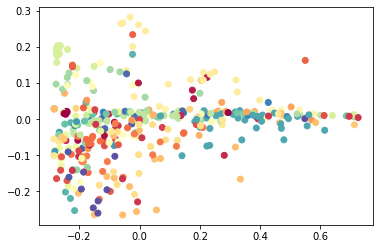

array([[ 4.26248268e-01,  6.42922174e-03],
       [ 1.12349956e-01,  1.41774540e-02],
       [-1.75359212e-01, -1.02044165e-01],
       [-3.00860993e-03, -9.85944598e-02],
       [-1.20631453e-01,  1.92353730e-02],
       [-2.83120398e-01,  2.87808758e-02],
       [-1.53720029e-01, -2.45928685e-01],
       [ 1.83261676e-01, -6.86651206e-03],
       [ 2.00247069e-01, -2.22132444e-02],
       [ 4.07498862e-01,  1.11406976e-02],
       [-7.10297970e-02, -1.83158488e-02],
       [-2.28462194e-01, -9.86414666e-03],
       [-2.29539461e-01, -2.19714312e-01],
       [-2.15533071e-01, -2.53351516e-01],
       [-2.45904240e-01, -2.02080466e-01],
       [-1.60918233e-01, -6.96444457e-02],
       [-1.47326018e-01, -1.69883735e-02],
       [-1.20223395e-01, -5.98743541e-02],
       [-2.61886543e-01, -4.69677497e-02],
       [ 7.10171875e-01,  7.50346413e-03],
       [ 7.11196638e-01,  6.36543127e-03],
       [ 2.72314410e-01,  4.62572678e-02],
       [-1.89476030e-01, -8.06126417e-02],
       [-7.

In [19]:
project2D_and_map_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_speaker_tfidf, newspaper_in_group.owner_ID)


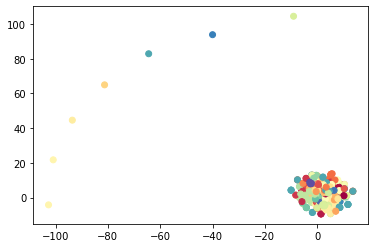

array([[ 6.46557212e-01,  3.29473257e+00],
       [ 7.23739910e+00,  2.99518299e+00],
       [ 2.05983579e-01,  5.40155935e+00],
       [ 1.91342592e+00,  7.01452160e+00],
       [ 1.73307538e+00,  3.09345388e+00],
       [ 2.38454270e+00,  3.43490124e+00],
       [-2.52571368e+00,  9.05946255e+00],
       [ 5.73903656e+00,  4.51550150e+00],
       [-9.98344898e+00,  4.27436924e+00],
       [ 8.48988438e+00,  6.05529547e+00],
       [-5.74201584e+00,  3.62910581e+00],
       [ 9.65847492e+00,  2.28468370e+00],
       [-3.83992076e-01,  8.55205059e+00],
       [-5.44735134e-01,  8.67514610e+00],
       [-3.42747033e-01,  8.46468163e+00],
       [ 3.53626800e+00,  6.94315100e+00],
       [ 1.13025961e+01,  1.17353749e+00],
       [ 1.03341236e+01,  7.56728506e+00],
       [-2.52733350e+00,  2.75694656e+00],
       [-5.44849586e+00,  4.02835131e+00],
       [-6.79056883e+00,  6.38595152e+00],
       [ 7.06285906e+00, -7.79899168e+00],
       [ 3.58006978e+00,  9.71772861e+00],
       [ 8.

In [20]:
project2D_and_map_TSNE(newspaper_in_group.newspaper, newspaper_to_index, newspaper_speaker_tfidf, newspaper_in_group.owner_ID)


### Project token TFIDF in 2D using PCA /TSNE an create a map

In [21]:
newspaper_token_tfidf = sparse.load_npz(FILE_NEWSPAPER_TOKEN_TFIDF)
newspaper_token_tfidf = newspaper_token_tfidf.toarray()

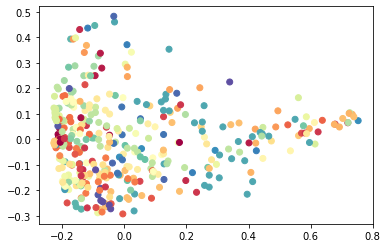

array([[ 5.49848962e-01,  7.87739378e-02],
       [ 2.25917051e-01,  6.49895180e-02],
       [-1.23757555e-01, -2.10893421e-01],
       [-8.00419046e-02, -1.34712401e-01],
       [ 8.66004027e-03,  3.71172118e-01],
       [ 7.19638295e-01,  6.51716795e-02],
       [-7.67683443e-02, -1.91637452e-01],
       [ 3.06725870e-01, -6.11597977e-02],
       [ 3.32793973e-02, -2.14219473e-01],
       [-3.13557954e-02,  4.60178623e-01],
       [-1.33402138e-01, -1.48852441e-01],
       [-1.90684487e-01, -8.74173673e-02],
       [-1.57984453e-01, -2.49477922e-01],
       [-1.38598109e-01, -2.73441214e-01],
       [-1.54798715e-01, -2.63768794e-01],
       [-1.68763127e-01, -1.00966251e-01],
       [-1.42951539e-01, -1.30397455e-01],
       [-1.91684379e-01,  7.55571593e-03],
       [-2.24853605e-01, -6.76765714e-03],
       [ 6.78741662e-01,  5.99095461e-02],
       [ 7.20563720e-01,  6.60275042e-02],
       [ 4.21504622e-01,  4.03451079e-02],
       [-2.12563191e-01,  5.13406479e-03],
       [ 5.

In [22]:
project2D_and_map_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_token_tfidf, newspaper_in_group.owner_ID)


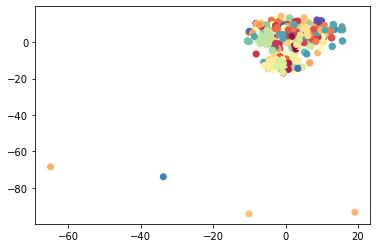

array([[-6.05351257e+00, -1.09632874e+01],
       [ 6.53699696e-01,  2.55244231e+00],
       [ 7.98303604e+00,  3.19801068e+00],
       [ 4.20523214e+00,  8.77816391e+00],
       [-6.29244471e+00,  9.81007957e+00],
       [-1.75615132e+00, -7.77952552e-01],
       [ 9.85594177e+00,  1.18224459e+01],
       [ 7.12534475e+00,  2.98287964e+00],
       [ 1.31721592e+01,  9.77989292e+00],
       [-7.14146709e+00,  8.48555279e+00],
       [-2.87160468e+00, -2.10545599e-01],
       [ 3.09519982e+00, -1.49587214e+00],
       [ 8.50047493e+00,  7.15956831e+00],
       [ 8.51792908e+00,  7.61859417e+00],
       [ 8.43988037e+00,  7.51535606e+00],
       [ 4.92381525e+00,  3.84089255e+00],
       [ 3.14205599e+00, -2.68786836e+00],
       [-1.61430165e-01,  1.14197798e+01],
       [-4.09555244e+00,  2.71526122e+00],
       [-2.58744907e+00, -1.73269832e+00],
       [-3.81870937e+00, -4.60096788e+00],
       [ 6.67241621e+00, -1.13376083e+01],
       [-8.87495652e-02,  9.72553062e+00],
       [-2.

In [23]:
project2D_and_map_TSNE(newspaper_in_group.newspaper, newspaper_to_index, newspaper_token_tfidf, newspaper_in_group.owner_ID)


### Bokeh plot of the above map

In [24]:
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Turbo256, Plasma, cividis, magma
from bokeh.models import LabelSet,Scatter
import bokeh.plotting as bpl
from bokeh.transform import factor_cmap

In [25]:
Y =  project2D_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_speaker_tfidf)

#
#Y = project2D_PCA(newspaper_in_group.newspaper, newspaper_to_index, newspaper_token_tfidf)

In [26]:
df = pd.DataFrame(
    {
        "x": Y[:, 0],
        "y": Y[:, 1],
        "group": newspaper_in_group.owner
    }
)

tools = ['pan','box_select', 'wheel_zoom', 'hover', 'reset','save','help']

groups = df['group'].unique()

color_map = factor_cmap("group", factors=sorted(groups),palette=magma(len(groups)))

# create figure and plot
p = bpl.figure(height=1000, width=1500)

for group_name,points in df.groupby('group'):
    
    source = bpl.ColumnDataSource(points)

    scat = p.scatter(x='x', y='y',
              fill_color= color_map,
              line_color = color_map,
              legend_label=group_name, source=source)
    
    scat.visible=False
    
    labels = LabelSet(x='x', y='y', text='group',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')
    
p.legend.click_policy="hide"

p.legend.label_text_font_size = '16px'
#Padding on the overall rectangle
p.legend.padding = 0
p.legend.spacing = 0
#Size of circular points
p.legend.glyph_height = 16
p.legend.glyph_width = 16
#Padding between label entries
p.legend.label_height = 0
p.legend.label_width = 0
bpl.show(p)